Jakość klasyfikatora w zależności od metod ekstrakcji cech:
1. nmfcc
2. tonnetz
3. spectral_contrast
4. melspectrogram
5. rms
6. chroma_stft

In [1]:
import os
import librosa
import pickle
import sklearn
import numpy
import time
import warnings
warnings.filterwarnings('ignore')

In [14]:
def features_class_func(y, sr, feature_class):
    if feature_class == 'nmfcc':
        output = librosa.feature.mfcc(y = y, sr = sr)
    elif feature_class == 'tonnetz':
        output = librosa.feature.tonnetz(y = y, sr = sr)
    elif feature_class == 'spectral_contrast':
        output = librosa.feature.spectral_contrast(y = y, sr = sr)
    elif feature_class == 'melspectrogram':
        output = librosa.feature.melspectrogram(y = y, sr = sr)
    elif feature_class == 'rms':
        output = librosa.feature.rms(y = y)
    elif feature_class == 'chroma_stft':
        output = librosa.feature.chroma_stft(y = y, sr = sr)
    else:
        print("ERROR! Bad feature_class name passed!")
        output = None
    return output

def create_database(features_class_list, class_size):
    train_audio_path = 'data/train/audio'
    commands = os.listdir(train_audio_path)[:-1]
    classes = []
    samples = dict.fromkeys(features_class_list, [])
    labels = dict.fromkeys(features_class_list, [])
    print("Databases generation in progress:")
    command_cnt = 0
    start = time.time()
    for command in commands:
        classes.append(command)
        command_cnt += 1
        sample_num = 0
        print(f'                                          ', end='\r')
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            delta = time.time() - start
            samples_done_number = (((command_cnt-1)*class_size)+sample_num)
            samples_remain_number = (len(commands)*class_size) - samples_done_number
            rt = delta/samples_done_number*samples_remain_number
            print(f'{command_cnt}/{len(commands)} -> {command}: {sample_num/class_size*100:.0f}%  RT: {rt:.3f}s', end='\r')
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            for feature_class in features_class_list:
                feature_list = features_class_func(y, sr, feature_class)
                features_seq = []
                for feature in feature_list:
                    features_seq.append(numpy.mean(feature))
                samples[feature_class] = samples[feature_class] + [features_seq]
                labels[feature_class] = labels[feature_class] + [command]
            if sample_num == class_size:
                break
    print("\nGeneration finished!\n")
    return classes, samples, labels

In [15]:
def train_model(train_size, test_size, k, classes, samples, labels):
    samples, labels = sklearn.utils.shuffle(samples, labels)
    
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for classname in classes:
        train_size_index = 0
        test_size_index = 0
        for i in range(len(labels)):
            if labels[i] == classname and train_size_index < train_size:
                train_samples.append(samples[i])
                train_labels.append(labels[i])
                train_size_index += 1
            elif labels[i] == classname and test_size_index < test_size:
                test_samples.append(samples[i])
                test_labels.append(labels[i])
                test_size_index += 1
            if train_size_index == train_size and test_size_index == test_size:
                break

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_samples, train_labels)

    predicted_labels = classifier.predict(test_samples)
    
    quality = numpy.sum(test_labels == predicted_labels) / len(test_labels) * 100;
    return quality

In [39]:
from matplotlib import pyplot as plt
import random

def find_optimal_feature_class(feature_class_list, k, database, class_size):
    classes, samples_dct, labels_dct = database
    quality_list =dict.fromkeys(feature_class_list, [])
    colors = ['ro-','bo-','ko-','co-','go-','mo-']
    range_check = range(1,50)
    for i in range_check:
        print(f'Progress of operation: {i/max(range_check)*100:.1f}%', end='\r')
        train_size = random.randint(40,100)
        test_size = class_size - train_size
        for feature_class in feature_class_list:
            quality = train_model(train_size, test_size, k, classes, samples_dct[feature_class], labels_dct[feature_class])
            quality_list[feature_class] = quality_list[feature_class] + [quality]
    plt.figure(figsize=(18,8))
    for feature_class in feature_class_list:
        plt.plot(range_check, quality_list[feature_class], colors[feature_class_list.index(feature_class)])
    plt.title("Zależność oceny klasyfikatora od metody ekstracji cech")
    plt.legend(feature_class_list)
    plt.grid()
    plt.xlabel("Numer próby")
    plt.ylabel("Quality")
    plt.show()

In [17]:
FEATURE_CLASS_LIST = ['nmfcc', 'tonnetz', 'spectral_contrast', 
                        'melspectrogram', 'rms', 'chroma_stft']
database = create_database(FEATURE_CLASS_LIST, 120)

Databases generation in progress:
30/30 -> zero: 100%  RT: 0.000s           
Generation finished!



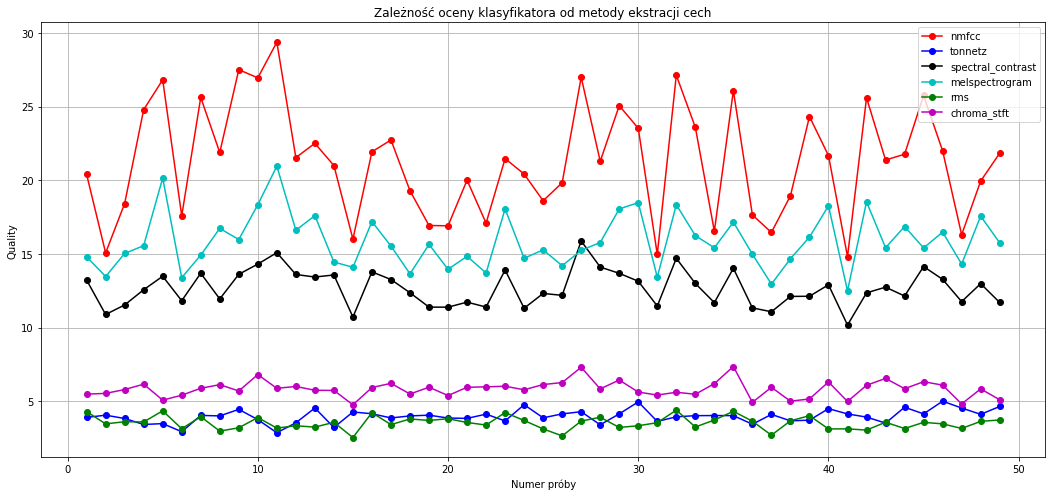

In [40]:
find_optimal_feature_class(FEATURE_CLASS_LIST, 5, database, 120)